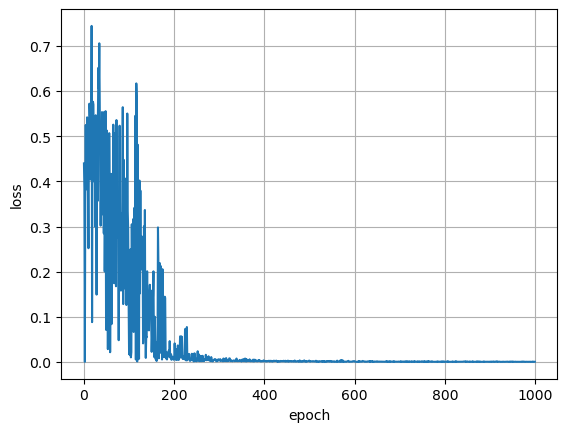

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#make Neural network
Nin = 3
M1 = 7
M2 = 8
W1 = np.random.random([M1,Nin])
b1 = np.random.random([M1,1])
W2 = np.random.random([M2, M1])
b2 = np.random.random([M2,1])
network = [W1,W2,b1,b2]

def relu(x):
    return np.maximum(0, x)

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def loss_function(y,t):
    return sum(0.5*(y-t)**2)

def forward(network, x):
    W1 = network[0]
    W2 = network[1]
    b1 = network[2]
    b2 = network[3]
    y1 = relu(W1@x  + b1)
    y2 = softmax(W2@y1 + b2)    
    return y2

#ランダムに入力を作る
def make_input():
    x0 = int(np.random.random()<0.5)
    x1 = int(np.random.random()<0.5)
    x2 = int(np.random.random()<0.5)
    teach = x2*4 + x1*2 + x0
    x  = np.array([[x2],[x1],[x0]])
    teach = np.array([[int(teach==0)],\
                      [int(teach==1)],\
                      [int(teach==2)],\
                      [int(teach==3)],\
                      [int(teach==4)],\
                      [int(teach==5)],\
                      [int(teach==6)],\
                      [int(teach==7)]])
    return x, teach

def numerical_deff(y1,y2,h):
    return (y2-y1)/2/h


COUNT=[]
LOSS=[]

h=1e-6;
rho = 0.7

#学習
for i in range(1000):
    x, teach = make_input()
    W1 = network[0]
    W2 = network[1]
    b1 = network[2]
    b2 = network[3]

    #数値偏微分
    grad1=np.zeros([M1, Nin])
    for m in range(M1):
        for n in range(Nin):
            W1 = network[0]
            W1n = np.copy(W1)
            W1n[m,n] = W1[m,n] - h
            network1 = [W1n,W2,b1,b2]
            out1 = forward(network1, x) 
            loss1 = loss_function(out1, teach)
            W1n[m,n] = W1n[m,n] + 2*h
            network1 = [W1n,W2,b1,b2]
            out2 = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad1[m, n] = numerical_deff(loss1, loss2, h)

    grad2=np.zeros([M2, M1])
    for m in range(M2):
        for n in range(M1):
            W2 = network[1]
            W2n = np.copy(W2)
            W2n[m,n] = W2[m,n] - h
            network1 = [W1,W2n,b1,b2]
            out1 = forward(network1, x) 
            loss1 = loss_function(out1, teach)
            W2n[m,n] = W2n[m,n] + 2*h
            network1 = [W1,W2n,b1,b2]
            out2 = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad2[m, n] = numerical_deff(loss1, loss2, h)

    grad3=np.zeros([M1, 1])
    for m in range(M1):
        for n in range(1):
            b1 = network[2]
            b1n = np.copy(b1)
            b1n[m,n] = b1[m,n] - h
            network1 = [W1,W2,b1n,b2]
            out1 = forward(network1, x) 
            loss1 = loss_function(out1, teach)
            b1n[m,n] = b1n[m,n] + 2*h
            network1 = [W1,W2,b1n,b2]
            out2 = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad3[m, n] = numerical_deff(loss1, loss2, h)

    grad4=np.zeros([M2, 1])
    for m in range(M2):
        for n in range(1):
            b2 = network[3]
            b2n = np.copy(b2)
            b2n[m,n] = b2[m,n] - h
            network1 = [W1,W2,b1,b2n]
            out1 = forward(network1, x) 
            loss1 = loss_function(out1, teach)
            b2n[m,n] = b2n[m,n] + 2*h
            network1 = [W1,W2,b1,b2n]
            out2 = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad4[m, n] = numerical_deff(loss1, loss2, h)

    #重み更新
    W1 = W1 - rho*grad1
    W2 = W2 - rho*grad2
    b1 = b1 - rho*grad3
    b2 = b2 - rho*grad4


    x, teach = make_input()
    network = [W1,W2,b1,b2]
    out = forward(network, x) 
    loss = loss_function(out, teach)
    COUNT.append(i)
    LOSS.append(loss)
    
plt.plot(COUNT, LOSS)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()
    


In [262]:
#学習後のニューラルネットで確認
x, teach = make_input()
network = [W1,W2,b1,b2]
out = forward(network, x)

print("input", x[2]+x[1]*2+x[0]*4)
print("output\n", np.round(out))

input [5]
output
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
